# Mandatory Challenge
## Context
You work in the data analysis team of a very important company. On Monday, the company shares some good news with you: you just got hired by a major retail company! So, let's get prepared for a huge amount of work!

Then you get to work with your team and define the following tasks to perform:   
1. You need to start your analysis using data from the past.  
2. You need to define a process that takes your daily data as an input and integrates it.  

You are in charge of the second part, so you are provided with a sample file that you will have to read daily. To complete you task, you need the following aggregates:
* One aggregate per store that adds up the rest of the values.
* One aggregate per item that adds up the rest of the values.

You can import the dataset `retail_sales` from Ironhack's database. 

## Your task
Therefore, your process will consist of the following steps:
1. Read the sample file that a daily process will save in your folder. 
2. Clean up the data.
3. Create the aggregates.
4. Write three tables in your local database: 
    - A table for the cleaned data.
    - A table for the aggregate per store.
    - A table for the aggregate per item.

## Instructions
* Read the csv you can find in Ironhack's database.
* Clean the data and create the aggregates as you consider.
* Create the tables in your local database.
* Populate them with your process.

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib as pl
%matplotlib inline
import pymysql
from sqlalchemy import create_engine

In [23]:
os.getcwd()

'/home/salva/Desktop/Suprafolder/Labs/W3/lab-df-calculation-and-transformation/your-code'

In [ ]:
# your code here
driver = "mysql+pymysql:"
user = "ironhacker_read"
password = "ir0nhack3r"
ip = "35.239.232.23"
database = "retail_sales"



In [ ]:
connection_string = f"{driver}//{user}:{password}@{ip}/{database}"
engine = create_engine(connection_string)

In [ ]:
query = """
SHOW TABLES
"""

db_tables = pd.read_sql(query, engine)
db_tables

In [ ]:
query = """
SELECT *
FROM raw_sales
"""

raw_sales = pd.read_sql(query, engine)

In [ ]:
query = """
SELECT *
FROM sales_by_item
"""

sales_by_item = pd.read_sql(query, engine)

In [ ]:
query = """
SELECT *
FROM sales_by_shop
"""

sales_by_shop = pd.read_sql(query, engine)

With above queries, tables would be manageable through Python. However,since I dont have access right now, and I have the tables in csv format, I am going to continue as if the tables would have beenn brought from sql.

Importing data from csv

In [24]:
raw_sales = pd.read_csv("raw_sales.csv")
sales_by_item_index = pd.read_csv("sales_by_item_index.csv")
sales_by_item = pd.read_csv("sales_by_item.csv")
sales_by_shop = pd.read_csv("sales_by_shop.csv")

### Cleaning raw_sales data - Checking data types, looking for suspicious data

In [25]:
raw_sales.head()

,date,shop_id,item_id,item_price,item_cnt_day
0,2015-01-04 00:00:00,29,1469,1199.0,1
1,2015-01-04 00:00:00,28,21364,479.0,1
2,2015-01-04 00:00:00,28,21365,999.0,2
3,2015-01-04 00:00:00,28,22104,249.0,2
4,2015-01-04 00:00:00,28,22091,179.0,1


In [26]:
raw_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545 entries, 0 to 4544
Data columns (total 5 columns):
date            4545 non-null object
shop_id         4545 non-null int64
item_id         4545 non-null int64
item_price      4545 non-null float64
item_cnt_day    4545 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 177.6+ KB


In [27]:
raw_sales = raw_sales.astype({"date": "datetime64[ns]"})

In [28]:
raw_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545 entries, 0 to 4544
Data columns (total 5 columns):
date            4545 non-null datetime64[ns]
shop_id         4545 non-null int64
item_id         4545 non-null int64
item_price      4545 non-null float64
item_cnt_day    4545 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 177.6 KB


In [29]:
raw_sales.head()

,date,shop_id,item_id,item_price,item_cnt_day
0,2015-01-04,29,1469,1199.0,1
1,2015-01-04,28,21364,479.0,1
2,2015-01-04,28,21365,999.0,2
3,2015-01-04,28,22104,249.0,2
4,2015-01-04,28,22091,179.0,1


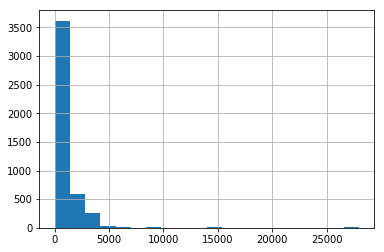

In [30]:
raw_sales['item_price'].hist(bins=20)

In [ ]:
# we can see above prices that are quite far from the rest. We have not enough info to consider them outliers, since the items could be just expensive belonging to a premium version or something of the like
# but for the sake of practising, lets just consider the extreme prices, outliers.

In [31]:
stats = raw_sales.describe().transpose()
stats["IQR"] = stats["75%"] - stats["25%"]
stats

,count,mean,std,min,25%,50%,75%,max,IQR
shop_id,4545.0,34.021122,16.565517,2.0,22.0,31.0,50.0,59.0,28.0
item_id,4545.0,11140.459406,6558.649572,30.0,4977.0,11247.0,16671.0,22162.0,11694.0
item_price,4545.0,1031.686121,2073.919990,3.0,249.0,479.0,1192.0,27990.0,943.0
item_cnt_day,4545.0,1.103630,0.536967,-1.0,1.0,1.0,1.0,10.0,0.0


In [35]:
outliers = pd.DataFrame(columns=raw_sales.columns)

iqr = stats.at["item_price","IQR"]
cutoff = iqr * 3
upper = stats.at["item_price","75%"] + cutoff
results = raw_sales[(raw_sales["item_price"] > upper)].copy()
outliers = outliers.append(results)

In [36]:
outliers.head()

,date,shop_id,item_id,item_price,item_cnt_day
78,2015-01-04,28,1971,4499.0,1
304,2015-01-04,25,1971,4499.0,1
356,2015-01-04,22,837,4600.0,1
400,2015-01-04,21,6675,26990.0,1
420,2015-01-04,27,1971,4499.0,1


In [37]:
clean_sales = raw_sales.drop(outliers.index, axis=0)

In [38]:
clean_sales.describe()

,shop_id,item_id,item_price,item_cnt_day
count,4461.000000,4461.000000,4461.000000,4461.000000
mean,34.127774,11229.204438,836.943156,1.104237
std,16.537640,6552.957563,906.395552,0.540829
min,2.000000,30.000000,3.000000,-1.000000
25%,22.000000,5240.000000,239.200000,1.000000
50%,31.000000,11369.000000,449.000000,1.000000
75%,50.000000,16790.000000,1129.000000,1.000000
max,59.000000,22162.000000,3999.000000,10.000000


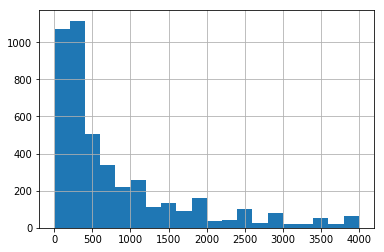

In [39]:
clean_sales['item_price'].hist(bins=20)

In [40]:
clean_sales.to_csv("sales_clean.csv")

### Cleaning sales by items and sales by shops

In [41]:
sales_by_item.head()

,item_id,item_earnings,total_items_sold,date
0,30,169.0,1,03/09/2019
1,31,363.0,1,03/09/2019
2,32,149.0,1,03/09/2019
3,42,299.0,1,03/09/2019
4,59,249.0,1,03/09/2019


In [42]:
sales_by_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 4 columns):
item_id             2955 non-null int64
item_earnings       2955 non-null float64
total_items_sold    2955 non-null int64
date                2955 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 92.4+ KB


In [43]:
sales_by_item = sales_by_item.astype({"date": "datetime64[ns]"})

In [44]:
sales_by_shop.head()

,shop_id,shop_earnings,total_items_sold,date
0,2,33023.5,27,03/09/2019
1,3,22481.0,11,03/09/2019
2,4,9787.0,13,03/09/2019
3,5,11046.0,15,03/09/2019
4,6,38784.0,50,03/09/2019


In [45]:
sales_by_shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 4 columns):
shop_id             90 non-null int64
shop_earnings       90 non-null float64
total_items_sold    90 non-null int64
date                90 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 2.9+ KB


In [46]:
sales_by_shop = sales_by_shop.astype({"date": "datetime64[ns]"})

### Aggregations

In [47]:
sales_by_item["item_id"].nunique()

985

In [57]:
agg_sales_by_item = sales_by_item.groupby(["item_id"])["total_items_sold", "item_earnings"].sum().head()

In [58]:
agg_sales_by_item.head()

,total_items_sold,item_earnings
item_id,,
30,3,507.0
31,3,1089.0
32,3,447.0
42,3,897.0
59,3,747.0


In [59]:
sales_by_shop["shop_id"].nunique()

45

In [60]:
agg_sales_by_shop = sales_by_shop.groupby(["shop_id"])[["shop_earnings"]].sum().head()

In [61]:
agg_sales_by_shop.head()

,shop_earnings
shop_id,
2,66047.0
3,44962.0
4,19574.0
5,22092.0
6,77568.0


In [62]:
agg_sales_by_item.to_csv("total_sales_by_item.csv")

In [63]:
agg_sales_by_shop.to_csv("total_sales_by_shop.csv")

### Uploading to the database

In [ ]:
driver = 'mysql+pymysql'
user = 'root'
password = 'ironhack'
ip = 'localhost'
database = 'retail_sales'

In [ ]:
connection_string = f'{driver}://{user}:{password}@{ip}/{database}'

In [ ]:
engine = create_engine(connection_string)

In [ ]:
clean_sales.to_sql("clean_sales",engine)

In [ ]:
agg_sales_by_item.to_sql("agg_sales_by_item", engine)

In [ ]:
agg_sales_by_shop.to_sql("agg_sales_by_shop", engine)